# Accessibility of London foodbanks

## 1. Get foodbanks

1. Independent foodbanks: Data from list published in the [Guardian](https://www.theguardian.com/society/2017/may/29/report-reveals-scale-of-food-bank-use-in-the-uk-ifan). 
2. Trussell Trust foodbanks listed on their [website](https://www.trusselltrust.org/get-help/find-a-foodbank/)

In [19]:
import pandas as pd
import numpy as np
from geopy.geocoders import Nominatim
import geopandas as gpd
from shapely.geometry import Point, Polygon

### Independent foodbanks

In [110]:
#clean up raw data
ind_raw = pd.read_csv("IFAN_members_London.csv", header=None)
ind_data = {"Name":[], "Postcode":[]}

for i in np.arange(0, len(ind_raw), 4):
    ind_data["Name"].append(ind_raw.iloc[i+1].values[0])
    ind_data["Postcode"].append(ind_raw.iloc[i+3].values[0])

ind = pd.DataFrame.from_dict(ind_data)

In [111]:
# get coordinates for foodbanks using Nominatim API and postcode
app = Nominatim(user_agent="mapping_projects")

geodata = {"lat": [], "lon": []}
for location in ind["Postcode"]:
    try:
        loc_data = app.geocode(location).raw
        geodata["lat"].append(loc_data["lat"])
        geodata["lon"].append(loc_data["lon"])
    except BaseException:
        geodata["lat"].append("Missing")
        geodata["lon"].append("Missing")                     

ind["lat"] = geodata["lat"]
ind["lon"] = geodata["lon"]

ind.to_csv("IFAN-members-london-final.csv")

### Trussell Trust members

In [20]:
#clean up raw data
trussell_raw = pd.read_excel("foodbanks-trussell.xlsx", header=None)
trussell_raw = trussell_raw.dropna()
trussell_raw = trussell_raw.loc[~trussell_raw[0].str.contains("location")]
trussell_raw = trussell_raw.loc[~trussell_raw[0].str.contains("details")]
trussell_raw = trussell_raw.loc[~trussell_raw[0].str.contains("from London")]
trussell_raw = trussell_raw.reset_index(drop = True)

In [61]:
data = {"Name":[], "Address":[]}

for i in np.arange(0, len(trussell_raw), 2):
    data["Name"].append(trussell_raw.iloc[i].values[0])
    data["Address"].append(trussell_raw.iloc[i+1].values[0])

trussell_cleaned = pd.DataFrame.from_dict(data)

In [62]:
values = {", UK": "", ", United Kingdom": ""}

for string in values.items():
    trussell_cleaned["Address"] = trussell_cleaned["Address"].str.replace(string[0], string[1])

In [ ]:
# get coordinates for region using Nominatim API
app = Nominatim(user_agent="mapping_projects")

geodata = {"lat": [], "lon": []}
for location in trussell["Address"]:
    try:
        loc_data = app.geocode(location).raw
        geodata["lat"].append(loc_data["lat"])
        geodata["lon"].append(loc_data["lon"])
    except BaseException:
        geodata["lat"].append("Missing")
        geodata["lon"].append("Missing")                     

trussell_cleaned["lat"] = geodata["lat"]
trussell_cleaned["lon"] = geodata["lon"]

trussell_cleaned.to_csv("trussell_cleaned.csv")

Did a lot more offline cleaning on this one ...

### save final list of foodbanks as shapefile

In [133]:
### Foodbanks
ind = pd.read_csv("IFAN-members-london-final.csv")
trussell = pd.read_csv("trussell_final.csv")
ind = ind.rename(columns={"Postcode":"Address"})
ind["Type"] = "Independent"
trussell["Type"] = "Trussell Trust"

#merge both datasets
df = pd.concat([ind, trussell], ignore_index=True)

#turn into geodataframe
geometry = [Point(xy) for xy in zip(df['lon'].astype(float), df['lat'].astype(float))]
gdf = gpd.GeoDataFrame(df, crs = 'EPSG:4326', geometry = geometry)
gdf.head()

,Name,Address,lat,lon,Type,geometry
0,St Alban's Foodbank,SE25 6RD,51.39822,-0.09156,Independent,POINT (-0.09156 51.39822)
1,South Norwood Community Kitchen,SE25 6TY,51.40005,-0.08001,Independent,POINT (-0.08001 51.40005)
2,St Alban's Foodbank,SE25 6RD,51.39822,-0.09156,Independent,POINT (-0.09156 51.39822)
3,Liberty Food Bank,SW16 4JS,51.41027,-0.12052,Independent,POINT (-0.12052 51.41027)
4,South Norwood Community Kitchen,SE25 6TY,51.40005,-0.08001,Independent,POINT (-0.08001 51.40005)


In [135]:
#filter out those outside of London
la = gpd.GeoDataFrame.from_file("London_Borough_Excluding_MHW.geojson")
la = la.to_crs(4326)
gdf = gpd.sjoin(gdf, la, how="inner")
gdf = gdf.reset_index(drop=True)

In [139]:
gdf.to_file("foodbanks-london-final.geojson", driver='GeoJSON')

## 2.  Get isochrones

In [6]:
import configparser
import os
import sys
import time

import openrouteservice
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, Polygon

#set config file
root = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))
config_file =  os.path.join(root, "config.cfg")

In [2]:
# Get API key
config = configparser.ConfigParser()
config.read(config_file)
apikey = config["openroutingservice"]["key"]
client = openrouteservice.Client(key=apikey)

In [3]:
#load foodbanks
gdf = gpd.GeoDataFrame.from_file("foodbanks-london-final.geojson")

# coordinates of all foodbanks
coords = list(zip(gdf['lon'].astype(float), gdf['lat'].astype(float)))

In [8]:
len(coords)

226

In [7]:
# put it all  in a loop
iso = []

#for coord in coords[0:10]:
for coord in coords:
    location = [coord]
    #print(location)
    response = openrouteservice.isochrones.isochrones(client, location, profile='foot-walking',
                                                      range_type='time', range=[900], location_type="start", 
                                                      smoothing=0,attributes=["area"], validate=True)
    
    data = {"center": [], "time": [], "geometry": [] }
    for isochrone in response['features']:
        data["center"].append(isochrone["properties"]["center"])
        data["time"].append(isochrone["properties"]["value"])
        data["geometry"].append(Polygon([list(coord) for coord in isochrone['geometry']['coordinates'][0]]))
    
    df_single = pd.DataFrame.from_dict(data)
    iso.append(df_single)
    time.sleep(3)
    
iso = pd.concat(iso, axis=0, ignore_index=True)

#convert isochrones to geo dataframe
giso = gpd.GeoDataFrame(iso, crs="EPSG:4326", geometry="geometry").sort_values("time", ascending=False)

ApiError: 403 ({'error': 'Quota exceeded'})

In [10]:
# save output as geojson
giso["center_lat"] = giso["center"].str[1]
giso["center_lon"] = giso["center"].str[0]
giso = giso.drop(columns="center")
giso.to_file("isochrones-walking-15min.geojson", driver='GeoJSON')

In [11]:
## join polygons where they overlap
times = []
geometry = []

for seconds in [900]:
    times.append(seconds)
    union = giso[giso["time"]==seconds]["geometry"].unary_union
    geometry.append(union)

giso_combined = pd.DataFrame()

giso_combined["time"] = times
giso_combined["geometry"] = geometry 
giso_combined = gpd.GeoDataFrame(giso_combined, crs="EPSG:4326", geometry="geometry").sort_values("time", ascending=False)

C:\Users\lisa.hornung\anaconda3\envs\py3_maps\lib\site-packages\pandas\core\dtypes\cast.py:1785: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  result[:] = values


## 3. Map

In [13]:
import rasterio
from rasterio.plot import show as rioshow
import matplotlib.pyplot as plt
import contextily as cx

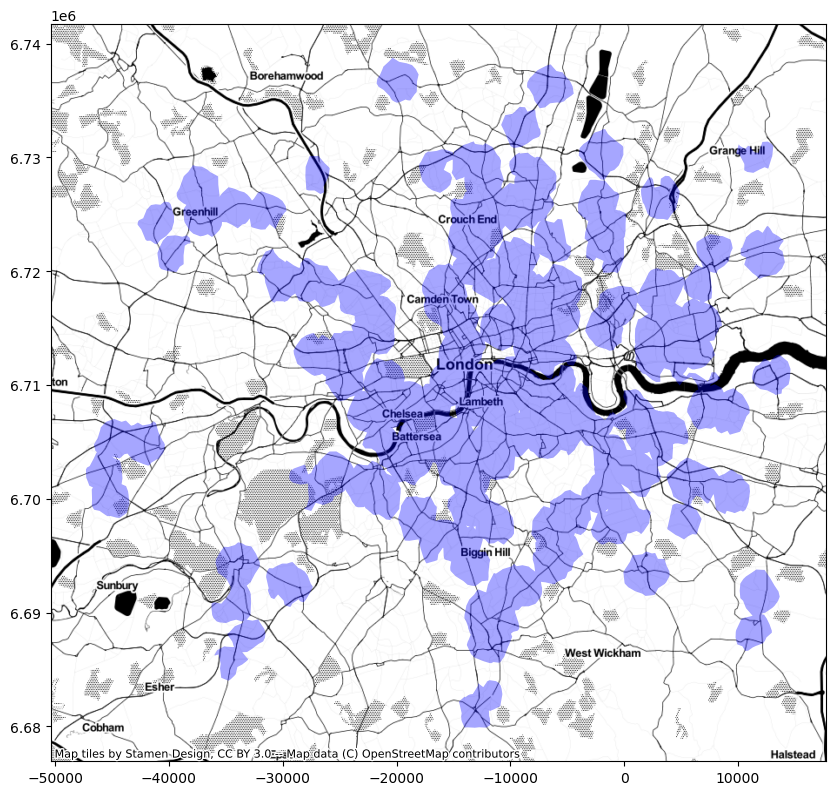

In [14]:
giso_plot = giso_combined.to_crs(3857)

fig,ax = plt.subplots(figsize=(10, 10))
giso_plot.plot(ax=ax, color="blue", alpha=0.35, zorder=2)
cx.add_basemap(ax=ax, crs=giso_plot.crs.to_string(), source=cx.providers.Stamen.Toner)

## London Authorities

In [45]:
la = gpd.GeoDataFrame.from_file("London_Borough_Excluding_MHW.geojson")

<AxesSubplot: >

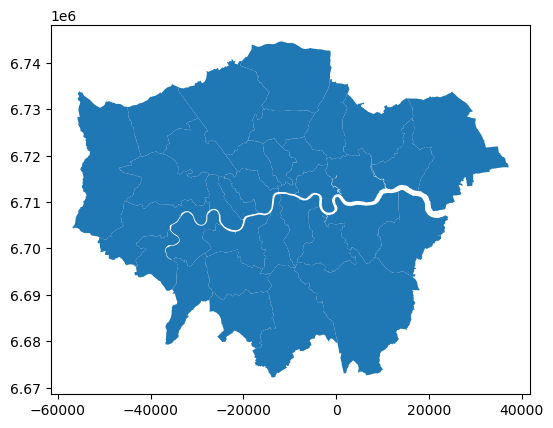

In [47]:
la.plot()

## London LSOAs

In [26]:
# get regions and lsoa
regions = pd.read_csv("Local_Authority_District_to_Region_(April_2021)_Lookup_in_England.csv")
lsoa = pd.read_csv("OA21_LSOA21_MSOA21_LAD22_EW_LU.csv")

#filter for London
regions = regions[regions["RGN21NM"]=="London"]
london_lsoa = pd.merge(lsoa, regions, left_on="lad22cd", right_on="LAD21CD", how="inner")

C:\Users\lisa.hornung\AppData\Local\Temp\ipykernel_2396\2058746312.py:2: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  lsoa_lookup = pd.read_csv("OA21_LSOA21_MSOA21_LAD22_EW_LU.csv")


In [42]:
### London LSOA shapefile
london = gpd.GeoDataFrame.from_file("LSOA_(Dec_2021)_Boundaries_Full_Clipped_EW_(BFC).shp")
london = london[london["LSOA21CD"].isin(london_lsoa["lsoa21cd"].unique())]

In [43]:
london

,OBJECTID,LSOA21CD,LSOA21NM,GlobalID,Shape__Are,Shape__Len,geometry
0,1,E01000001,City of London 001A,92527a6c-53df-4e35-b1f3-5c2d7d656d70,1.298653e+05,2635.767993,"POLYGON ((532151.537 181867.433, 532152.500 18..."
1,2,E01000002,City of London 001B,44c8af04-33f1-4750-96d9-160188d60c32,2.284198e+05,2707.816821,"POLYGON ((532634.497 181926.016, 532632.048 18..."
2,3,E01000003,City of London 001C,c41a09e9-7e85-48c3-b7cb-b1b5cdf77579,5.905420e+04,1224.573160,"POLYGON ((532153.703 182165.155, 532158.250 18..."
3,4,E01000005,City of London 001E,b379f8ac-8a7d-4327-ac2b-93a8981454f5,1.895777e+05,2275.805344,"POLYGON ((533619.062 181402.364, 533639.868 18..."
4,5,E01000006,Barking and Dagenham 016A,2c7c35e9-2a95-48d7-b30c-cc01f36094d5,1.465370e+05,1966.092607,"POLYGON ((545126.852 184310.838, 545145.213 18..."
...,...,...,...,...,...,...,...
33711,33712,E01035718,Westminster 019G,9538ba5f-679a-4654-8263-5d504bfd8546,2.671900e+06,10740.132994,"POLYGON ((528044.949 180617.984, 528046.344 18..."
33712,33713,E01035719,Westminster 021F,83cbd77a-6a49-4ffe-aa13-683f1428dac1,9.294961e+04,2013.141792,"POLYGON ((530267.000 178811.300, 530265.750 17..."
33713,33714,E01035720,Westminster 021G,ad242c27-b5d0-494b-af4b-0eeb1e9cb6a0,1.061637e+05,2229.186337,"POLYGON ((529856.151 178761.747, 529856.859 17..."
33714,33715,E01035721,Westminster 023H,db86fa3a-db44-430e-82e0-e1e8ce83a68a,2.168432e+05,2738.810595,"POLYGON ((528641.815 178630.886, 528635.688 17..."


<AxesSubplot: >

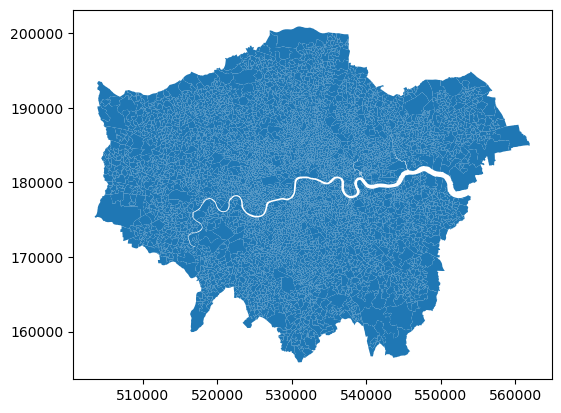

In [44]:
london.plot()

## Scraping - failed

In [23]:
#request = requests.get("https://www.foodaidnetwork.org.uk/our-members")
url = "https://www.trusselltrust.org/get-help/find-a-foodbank/"
headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:106.0) Gecko/20100101 Firefox/106.0'}
result = requests.get(url, headers=headers)

#russell = requests.json()

In [ ]:
"https://interactive.guim.co.uk/tools/tables/embed/index.html?spreadsheet=1HwmTt1GWBlyLbDt_lT2yrQyLSat1z-TQEE-X2MKQS9M"

In [24]:
soup = BeautifulSoup(result.content, 'html.parser')

In [26]:
soup

<!DOCTYPE html>

<html lang="en-GB">
<head>
<meta charset="utf-8"/>
<meta content="width=device-width, initial-scale=1" name="viewport"/>
<meta content="telephone=no" name="format-detection"/>
<title>Find a Food Bank - The Trussell Trust</title>
<link href="http://gmpg.org/xfn/11" rel="profile"/>
<link href="https://www.trusselltrust.org/xmlrpc.php" rel="pingback"/>
<!-- Critical CSS -->
<style>
		.btn {background-repeat: repeat!important;}
	</style>
<!-- LoadCSS (stylesheets after the fact) -->
<script>
		function loadCSS(e,o,n,s){"use strict";var t=window.document.createElement("link"),l=o||window.document.getElementsByTagName("script")[0],c=window.document.styleSheets;return t.rel="stylesheet",t.href=e,t.media="only x",s&&(t.onload=s),l.parentNode.insertBefore(t,l),t.onloadcssdefined=function(o){for(var n,s=0;s<c.length;s++)c[s].href&&c[s].href.indexOf(e)>-1&&(n=!0);n?o():setTimeout(function(){t.onloadcssdefined(o)})},t.onloadcssdefined(function(){t.media=n||"screen, print"}),t}
		l

In [13]:
request = requests.get("https://www.trusselltrust.org/")